In [30]:
import torch
import os.path as osp
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import collections

def get_cuhk_person_id():
    root = '/home/linhuadong/dataset/cuhk_sysu'
    # load all images and build a dict from image to boxes
    all_imgs = loadmat(osp.join(root, "annotation", "Images.mat"))
    all_imgs = all_imgs["Img"].squeeze()
    name_to_boxes = {}
    name_to_pids = {}
    unlabeled_pid = 5555  # default pid for unlabeled people
    for img_name, _, boxes in all_imgs:
        img_name = str(img_name[0])
        boxes = np.asarray([b[0] for b in boxes[0]])
        boxes = boxes.reshape(boxes.shape[0], 4)  # (x1, y1, w, h)
        valid_index = np.where((boxes[:, 2] > 0) & (boxes[:, 3] > 0))[0]
        assert valid_index.size > 0, "Warning: {} has no valid boxes.".format(img_name)
        boxes = boxes[valid_index]
        name_to_boxes[img_name] = boxes.astype(np.int32)
        name_to_pids[img_name] = unlabeled_pid * np.ones(boxes.shape[0], dtype=np.int32)

    def set_box_pid(boxes, box, pids, pid):
        for i in range(boxes.shape[0]):
            if np.all(boxes[i] == box):
                pids[i] = pid
                return

    # assign a unique pid from 1 to N for each identity
    train = loadmat(osp.join(root, "annotation/test/train_test/Train.mat"))
    train = train["Train"].squeeze()
    for index, item in enumerate(train):
        scenes = item[0, 0][2].squeeze()
        for img_name, box, _ in scenes:
            img_name = str(img_name[0])
            box = box.squeeze().astype(np.int32)
            set_box_pid(name_to_boxes[img_name], box, name_to_pids[img_name], index + 1)

    person_ids = []
    for name in name_to_pids.keys():
        person_ids += name_to_pids[name].tolist()
    return person_ids

def get_prw_person_id():

    def _load_split_img_names(root):
        imgs = loadmat(osp.join(root, "frame_train.mat"))["img_index_train"]
        return [img[0][0] + ".jpg" for img in imgs]

    root = '/home/linhuadong/dataset/PRW'
    annotations = []
    imgs = loadmat(osp.join(root, "frame_train.mat"))["img_index_train"]
    imgs = _load_split_img_names(root)
    for img_name in imgs:
        anno_path = osp.join(root, "annotations", img_name)
        anno = loadmat(anno_path)
        box_key = "box_new"
        if box_key not in anno.keys():
            box_key = "anno_file"
        if box_key not in anno.keys():
            box_key = "anno_previous"

        rois = anno[box_key][:, 1:]
        ids = anno[box_key][:, 0]
        rois = np.clip(rois, 0, None)  # several coordinates are negative

        assert len(rois) == len(ids)

        rois[:, 2:] += rois[:, :2]
        ids[ids == -2] = 5555  # assign pid = 5555 for unlabeled people
        annotations.append(
            {"pids": ids.astype(np.int32)}
        )
    person_ids = []
    
    for i in range(len(annotations)):
        person_ids += annotations[i]["pids"].tolist()
    return person_ids

def get_person_id_nums(person_ids):
    unique_person_ids = collections.defaultdict(list)
    for id in person_ids:
        unique_person_ids[id] = 0
    for id in person_ids:
        unique_person_ids[id] += 1
    person_id_nums = []
    for id in unique_person_ids.keys():
        person_id_nums.append(unique_person_ids[id])
    person_id_nums.sort(reverse=True)
    return unique_person_ids, person_id_nums

def vis(person_id_nums, name):
    plt.figure(figsize=(4, 4), dpi=100)
    plt.xticks(fontsize=12)  # 默认字体大小为10
    plt.title(name)
    plt.yticks(fontsize=12)
    plt.xlabel("Sorted Identity Index", fontsize=12)
    plt.ylabel("Instance Number", fontsize=12)
    plt.plot(np.arange(len(person_id_nums[1:])), person_id_nums[1:])
    # plt.savefig(f'./file/{name}_id_distributation.eps', dpi=100, format='eps', bbox_inches='tight', pad_inches=0)
    plt.show()


def vis_long_tail(unique_person_ids):
    unique_person_ids_ = sorted(unique_person_ids.items(), key=lambda x: x[1], reverse=True)
    unique_person_ids_num = [a[1] for a in unique_person_ids_]
    plt.figure(figsize=(4, 4), dpi=100)
    plt.xticks(fontsize=12)  # 默认字体大小为10
    plt.yticks(fontsize=12)
    plt.xlabel("Sorted Identity Index", fontsize=12)
    plt.ylabel("Instance Number", fontsize=12)
    plt.plot(np.arange(len(unique_person_ids_[1:])), unique_person_ids_num[1:])
    # plt.savefig(f'./file/{name}_id_distributation.eps', dpi=100, format='eps', bbox_inches='tight', pad_inches=0)
    plt.show()


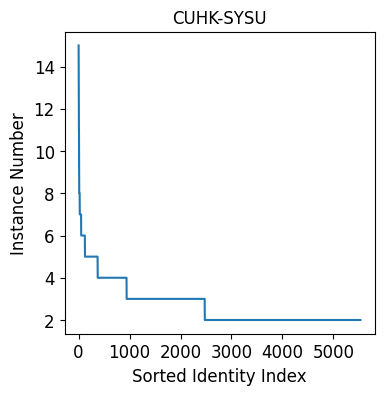

In [14]:
person_ids = get_cuhk_person_id()
unique_person_ids, person_id_nums = get_person_id_nums(person_ids)
vis(person_id_nums, 'CUHK-SYSU')
# vis_long_tail(unique_person_ids)

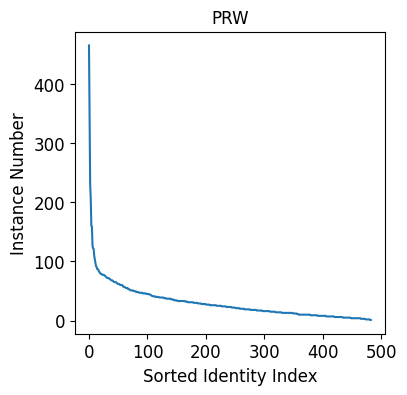

In [15]:
person_ids = get_prw_person_id()
unique_person_ids, person_id_nums = get_person_id_nums(person_ids)
vis(person_id_nums, 'PRW')

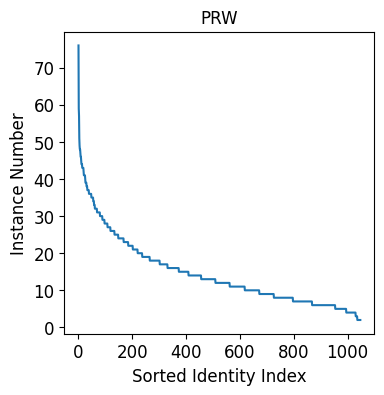

In [35]:
pseudo_label = torch.load("/home/linhuadong/DNFNet/jobs/prw_protonorm2/saved_file/pseudo_labels.pth")[0]
unique_person_ids, person_id_nums = get_person_id_nums(pseudo_label)
person_id_nums = torch.tensor(person_id_nums)
person_id_nums = person_id_nums[person_id_nums!=1]
vis(person_id_nums, 'PRW')

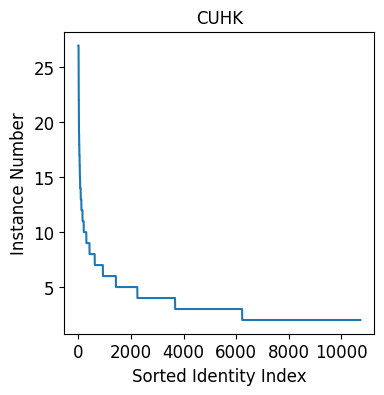

In [36]:
pseudo_label = torch.load("/home/linhuadong/DNFNet/jobs/cuhk_oimnetpp/saved_file/pseudo_labels.pth")[0]
unique_person_ids, person_id_nums = get_person_id_nums(pseudo_label)
person_id_nums = torch.tensor(person_id_nums)
person_id_nums = person_id_nums[person_id_nums!=1]
vis(person_id_nums, 'CUHK')